## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(0)

## Importing the dataset

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()
df = pd.DataFrame(boston.data, columns = boston.feature_names)
df["MEDV"] = boston.target

In [3]:
df.shape

(506, 14)

In [4]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Feature scaling

In [5]:
X_train = df.drop('MEDV', axis=1).values
y_train = df['MEDV'].values

In [6]:
# For chi-square test
y_train_cat = df['MEDV'] >= 22
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_cat = le.fit_transform(y_train_cat)

In [8]:
# For chi-square test and variance threshold
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_minmax = scaler.fit_transform(X_train)

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Dimensionality Reduction - Filter Method

## Variance Threshold

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html

Feature selection, filter method

Unsupervised

Works for both continuous and one hot encoded features

Needs feature scaling (but it can't be Standard Scaler)

### Fitting

In [13]:
from sklearn.feature_selection import VarianceThreshold
cols = df.drop('MEDV', axis=1).columns
def variance_threshold_selector(X_train, threshold):
    selector = VarianceThreshold(threshold)
    selector.fit(X_train)
    col_names = cols
    col_bools = selector.get_support()
    relevant_cols = [col_name for col_name, col_bool in zip(col_names, col_bools) if col_bool == True]
    irrelevant_cols = [col_name for col_name, col_bool in zip(col_names, col_bools) if col_bool == False]
    df_selected = df[relevant_cols]
    df_removed = df[irrelevant_cols]
    return (df_selected, df_removed)
df_selected, df_removed = variance_threshold_selector(X_train_minmax, 0.01) # Change here 
# 0.0 to remove constant features, 0.01 to remove quasi-contant features

### Selecting

In [14]:
selected_features_var = list(df_selected.columns)
removed_features_var = list(df_removed.columns)

In [15]:
selected_features_var

['ZN',
 'INDUS',
 'CHAS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT']

In [16]:
removed_features_var

['CRIM']

## Chi-Squared Test

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html

Feature selection, filter method

Supervised

Only works for one hot encoded features

Only works for classification

Needs feature scaling (but it can't be Standard Scaler)

### Fitting

In [20]:
from sklearn.feature_selection import chi2
chi_scores = chi2(X_train_minmax, y_train_cat)

### Visualising

,p-value
B,1.290574e-01
CHAS,7.971755e-02
RM,2.767903e-02
DIS,6.525865e-03
PTRATIO,2.472616e-03
CRIM,1.270929e-03
AGE,1.594477e-04
NOX,3.522787e-05
INDUS,7.555366e-06
TAX,4.143725e-07


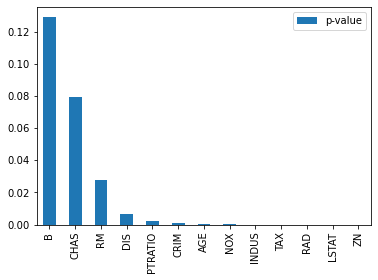

In [21]:
df_p_values = pd.DataFrame({'p-value': chi_scores[1]})
df_p_values.index = df.drop('MEDV', axis=1).columns
df_p_values.sort_values(by='p-value', ascending=False , inplace=True)
df_p_values.plot.bar()
df_p_values

### Selecting

In [23]:
alpha = 0.05 # Change here
selected_features_chi = list(df_p_values[df_p_values['p-value'] <= alpha].index)
removed_features_chi = list(df_p_values[df_p_values['p-value'] > alpha].index)

In [24]:
selected_features_chi

['RM',
 'DIS',
 'PTRATIO',
 'CRIM',
 'AGE',
 'NOX',
 'INDUS',
 'TAX',
 'RAD',
 'LSTAT',
 'ZN']

In [25]:
removed_features_chi

['B', 'CHAS']

## Correlation Threshold

Feature selection, filter method

Supervised / Unsupervised

Works for both continuous and one hot encoded features

Works for both regression and classification

Needs feature scaling

### Visualising dataframe correlations

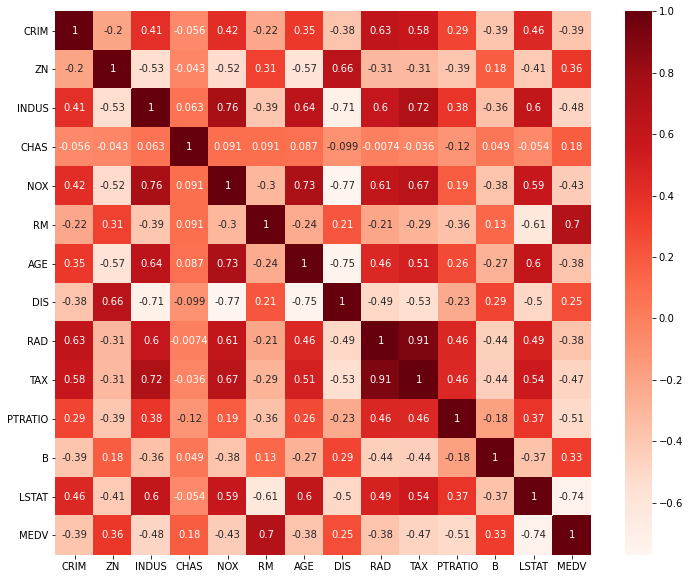

In [26]:
plt.figure(figsize=(12, 10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap='Reds')

### Selecting features with strong correlation with the dependent variable

In [27]:
cor_y = abs(cor['MEDV'])
selected_features_cor = cor_y[cor_y > 0.4] # Change here
df_selected = df[selected_features_cor.index]

### Visualising relevant dataframe correlations

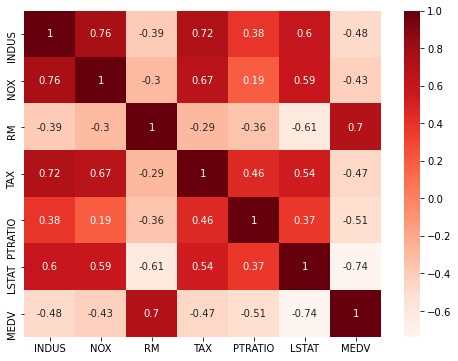

In [29]:
plt.figure(figsize=(8, 6))
cor = df_selected.corr()
sns.heatmap(cor, annot=True, cmap='Reds')

### Selecting features with weak correlation with every other feature, keeping the one most correlated with the dependent variable

In [30]:
# Remove: RM, INDUS, NOX

In [31]:
df_selected = df_selected[['LSTAT', 'PTRATIO', 'TAX']] # >= 0.6

### Selecting

In [32]:
selected_features_cor = list(df_selected.columns)
removed_features_cor = list(set(df.drop('MEDV', axis=1).columns) - set(selected_features_cor))

In [33]:
selected_features_cor

['LSTAT', 'PTRATIO', 'TAX']

In [34]:
removed_features_cor

['CRIM', 'B', 'NOX', 'INDUS', 'CHAS', 'RM', 'AGE', 'RAD', 'ZN', 'DIS']

# Dimensionality Reduction - Wrapper Method

## Backward Elimination

https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html

Feature selection, wrapper method

Supervised

Works for both continuous and one hot encoded features

Works for both regression and classification

Needs feature scaling

### Fitting

In [35]:
import statsmodels.api as sm
feat_cols = list(df.drop('MEDV', axis=1).columns)
pmax = 1
while (len(feat_cols) > 0):
    p = []
    const_col = df[feat_cols]
    const_col = sm.add_constant(const_col)
    model = sm.OLS(y_train, const_col).fit()
    p = pd.Series(model.pvalues[1:], index=feat_cols)
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax > 0.05): # Change here
        feat_cols.remove(feature_with_p_max)
    else:
        break

### Selecting

In [36]:
selected_features_back = list(feat_cols)
removed_features_back = list(set(df.drop('MEDV', axis=1).columns) - set(feat_cols))

In [37]:
selected_features_back

['CRIM',
 'ZN',
 'CHAS',
 'NOX',
 'RM',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT']

In [38]:
removed_features_back

['INDUS', 'AGE']

## Recursive Feature Elimination (RFE)

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

Supervised

Feature selection, wrapper method

Works for both continuous and one hot encoded features

Works for both regression and classification

Feature scaling depends on the model used (usually not required)

In [39]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.svm import SVR # Has to use linear kernel
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

high_score = 0
optimal_n = 0
ns = np.arange(1, df.drop('MEDV', axis=1).shape[1] + 1)
score_list = []
for n in ns:
    X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_train, y_train, test_size=0.3, random_state=0)
    model = LinearRegression() # Change here
    rfe = RFE(model, n_features_to_select = n)
    X_train_rfe = rfe.fit_transform(X_train_temp, y_train_temp)
    X_test_rfe = rfe.transform(X_test_temp)
    model.fit(X_train_rfe, y_train_temp)
    score = model.score(X_test_rfe, y_test_temp)
    score_list.append(score)
    if(score > high_score):
        high_score = score
        optimal_n = n

### Visualising

In [40]:
print("Possible optimum number of features: %d" %optimal_n)
print("Score with %d features: %f" %(optimal_n, high_score))
df_selected = pd.DataFrame({'Score': score_list})
df_selected.index = range(1, len(df_selected) + 1) # Number of Features
df_selected.sort_values(by='Score')

Possible optimum number of features: 11
Score with 11 features: 0.675177


,Score
1,0.521805
3,0.598559
2,0.606979
4,0.618632
6,0.628443
5,0.630139
7,0.641448
8,0.647980
9,0.655982
10,0.663581


In [41]:
cols = list(df.drop('MEDV', axis=1))
model = LinearRegression()
rfe = RFE(model, n_features_to_select=optimal_n)      
X_rfe = rfe.fit_transform(X_train, y_train)
model.fit(X_rfe, y_train)              
temp = pd.Series(rfe.support_, index = cols)

### Selecting

In [42]:
selected_features_rfe = list(temp[temp == True].index)
removed_features_rfe = list(temp[temp == False].index)

In [43]:
selected_features_rfe

['CRIM',
 'ZN',
 'CHAS',
 'NOX',
 'RM',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT']

In [44]:
removed_features_rfe

['INDUS', 'AGE']

# Dimensionality Reduction - Embedded Method

## LassoCV

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html

Supervised

Feature selection, embedded method

Works for both continuous and one hot encoded features

Works for both regression and classification

Needs feature scaling

### Fitting

In [45]:
from sklearn.linear_model import LassoCV
reg = LassoCV()
reg.fit(X_train, y_train)
coef = pd.Series(reg.coef_, index = df.drop('MEDV', axis=1).columns)
coef = coef.sort_values()

### Visualising

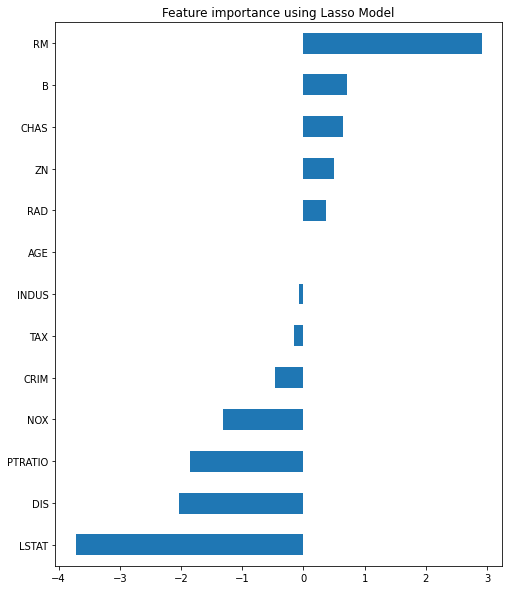

In [46]:
plt.figure(figsize=(8, 10))
plt.title("Feature importance using Lasso Model")
coef.plot(kind = "barh", )

### Selecting

In [47]:
selected_features_lasso = list(coef[coef != 0].index)
removed_features_lasso = list(coef[coef == 0].index)

In [48]:
selected_features_lasso

['LSTAT',
 'DIS',
 'PTRATIO',
 'NOX',
 'CRIM',
 'TAX',
 'INDUS',
 'RAD',
 'ZN',
 'CHAS',
 'B',
 'RM']

In [49]:
removed_features_lasso

['AGE']

# Putting all selections together

In [50]:
def get_true_false(selected_features, features):
    selected_t_f = []
    for feature in features:
        if feature in selected_features:
            selected_t_f.append(True)
        else:
            selected_t_f.append(False)
    return selected_t_f

In [51]:
features = sorted(df.drop('MEDV', axis=1).columns)
df_selections = pd.DataFrame({'Feature': features,
                              'Variance': get_true_false(selected_features_var, features),
                              'Chi-Squared': get_true_false(selected_features_chi, features),
                              'Correlation': get_true_false(selected_features_cor, features),
                              'Backward': get_true_false(selected_features_back, features),
                              'RFE': get_true_false(selected_features_rfe, features),
                              'Lasso': get_true_false(selected_features_lasso, features)})
df_selections['Total'] = np.sum(df_selections, axis=1)
df_selections = df_selections.sort_values(['Total', 'Feature'], ascending=False)
df_selections.index = range(1, len(df_selections) + 1)
df_selections

,Feature,Variance,Chi-Squared,Correlation,Backward,RFE,Lasso,Total
1,TAX,True,True,True,True,True,True,6
2,PTRATIO,True,True,True,True,True,True,6
3,LSTAT,True,True,True,True,True,True,6
4,ZN,True,True,False,True,True,True,5
5,RM,True,True,False,True,True,True,5
6,RAD,True,True,False,True,True,True,5
7,NOX,True,True,False,True,True,True,5
8,DIS,True,True,False,True,True,True,5
9,CRIM,False,True,False,True,True,True,4
10,CHAS,True,False,False,True,True,True,4


In [52]:
final_selected = list(df_selections[df_selections['Total'] > 3]['Feature'])

In [53]:
final_selected

['TAX',
 'PTRATIO',
 'LSTAT',
 'ZN',
 'RM',
 'RAD',
 'NOX',
 'DIS',
 'CRIM',
 'CHAS',
 'B']

# Fitting a model

## All features

In [54]:
X = df.drop('MEDV', axis=1).values
y = df['MEDV'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [55]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'gamma': [0, 0.5, 1],
    'min_child_weight': [6, 10],
    'subsample': [0.6, 0.9],
    'colsample_bytree': [0.6, 0.8]
}
grid = GridSearchCV(XGBRegressor(), param_grid, n_jobs=-1, cv=5, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   36.7s finished


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [56]:
print(grid.best_params_)
print(grid.best_score_)
y_pred = grid.predict(X_test)

{'colsample_bytree': 0.6, 'gamma': 1, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.9}
0.8744563494396491


In [57]:
from sklearn import metrics
print(metrics.r2_score(y_test, y_pred))
print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.mean_squared_error(y_test, y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

0.8175771422815088
2.4643855584295173
15.398523051547988
3.924095188899982


In [58]:
(0.8745 + 0.8289 + 0.8379 + 0.8480 + 0.8676 + 0.8601) / 6

0.8528333333333333

In [59]:
(0.8176 + 0.9106 + 0.8888 + 0.8781 + 0.8682 + 0.8568) / 6

0.8700166666666665

## Selected features

In [60]:
df = df[final_selected]
X = df.values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [62]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'gamma': [0, 0.5, 1],
    'min_child_weight': [6, 10],
    'subsample': [0.6, 0.9],
    'colsample_bytree': [0.6, 0.8]
}
grid = GridSearchCV(XGBRegressor(), param_grid, n_jobs=-1, cv=5, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   18.8s finished


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [63]:
print(grid.best_params_)
print(grid.best_score_)
y_pred = grid.predict(X_test)

{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.6}
0.8613666796716395


In [64]:
from sklearn import metrics
print(metrics.r2_score(y_test, y_pred))
print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.mean_squared_error(y_test, y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

0.8485235736787883
2.59861278659419
11.591725591124948
3.4046623314397784


In [65]:
(0.8485 + 0.8921 + 0.8337 + 0.8294 + 0.9020 + 0.8325) / 6

0.8563666666666666

In [66]:
(0.8614 + 0.8393 + 0.8410 + 0.8539 + 0.8348 + 0.8577) / 6

0.8480166666666666

## Using RandomizedSearchCV

In [72]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'gamma': [0, 0.5, 1],
    'min_child_weight': [6, 10],
    'subsample': [0.6, 0.9],
    'colsample_bytree': [0.6, 0.8]
}
random_grid = RandomizedSearchCV(XGBRegressor(), param_grid, n_iter=20, n_jobs=-1, cv=5, verbose=1)
random_grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.4s finished


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, reg_alpha=None,
                                       

In [73]:
print(random_grid.best_params_)
print(random_grid.best_score_)
y_pred = random_grid.predict(X_test)

{'subsample': 0.9, 'min_child_weight': 10, 'max_depth': 3, 'gamma': 1, 'colsample_bytree': 0.6}
0.8601442272081442


In [74]:
from sklearn import metrics
print(metrics.r2_score(y_test, y_pred))
print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.mean_squared_error(y_test, y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

0.8383843602001705
2.645191208312386
12.36762837156647
3.516763906145317
